### IMPORTS

In [18]:
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface
from Aux.CSVObjects import *
from Aux.ReactorPhysicsObjects import *



### ST.ST. THERMAL HYDRAULICS

In [19]:
_dt = 1e321
gravity = 9.81
Dh = 0.0158276279311347000000
perim = 0.07267978843558340
area = 0.000287587162368000000
temp_tolerance = 1e-10
max_temp_iterations = 1000
nZones=100
L0 = 0.0
L1 = 1.70
fluid = FluidRelation(cp=1983, mu=0.00744, k=1.44, rho_0 = 2715.13, drho_dT=-0.513)
pressure_bc = 0.0
T_bc = 900.0
MDOT_MAX = 0.120101854 # Set to have a 9.1725 second residence time in the main core.
fric = 'type1'
heat_source = [0.0]*nZones # heat source in W/m3

# Change mdot based on csv values:
mdot_csv = load_csv('Data/mass_flow_startup.csv')
mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=0.0, x_label='time', y_label='mdot')

#################
# CHANNEL SETUPS
#################
ch = Channel(gravity=gravity,
             Dh=Dh,
             area=area,
             temp_tolerance=temp_tolerance,
             max_temp_iterations=max_temp_iterations,
             nZones=nZones,
             L0=L0,
             L1=L1,
             fluid=fluid,
             pressure_bc=pressure_bc,
             T_bc=T_bc,
             mdot_bc=mdot_bc,
             fric=fric,
             heat_source=heat_source)

upper_plenum = Channel(gravity=gravity,
                       Dh=Dh,
                       area=1.5070061E-04,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

external_loop = Channel(gravity=gravity,
                       Dh=Dh,
                       area=2.9090676215E-04,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

lower_plenum = Channel(gravity=gravity,
                       Dh=Dh,
                       area=2.15740E-04,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

# Interfaces to handle data passing from one channel to another.
ch_to_up = ChannelInterface(ch1=ch, ch2=upper_plenum)
up_to_ex = ChannelInterface(ch1=upper_plenum, ch2=external_loop)
ex_to_lp = ChannelInterface(ch1=external_loop, ch2=lower_plenum)
lp_to_ch = ChannelInterface(ch1=lower_plenum, ch2=ch)

# Solution order - main channel -> plenum -> external loop -> lower plenum -> main channel
ch.solve_channel_TH(_dt=_dt)
ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

upper_plenum.solve_channel_TH(_dt=_dt)
up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

external_loop.solve_channel_TH(_dt=_dt)
ex_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

lower_plenum.solve_channel_TH(_dt=_dt)
lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

# End
print(ch.get_channel_residence_time())
print(upper_plenum.get_channel_residence_time())
print(external_loop.get_channel_residence_time())
print(lower_plenum.get_channel_residence_time())


Channel solved after 1 iterations!
Channel solved after 2 iterations!
Channel solved after 2 iterations!
Channel solved after 2 iterations!
9173029.225688461
2827543.9910552916
5458184.05960391
4047855.8157811835


### STEADY STATE TRACERS

In [20]:
tracer_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']
initial_value_tracers = 0.0
scheme_tracers = 'upwind'
# GEOMETRIC MULTISCALE
# decay_consts = [0.01334, 0.03273, 0.1208, 0.3029, 0.8498, 2.854]
# beta = [0.000228, 0.001177, 0.001124, 0.002522, 0.001036, 0.000434]

# SINGH ET AL NONLINEAR DYNAMIC MODEL
decay_consts = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01]
beta = [2.23e-4, 14.57e-4, 13.07e-4, 26.28e-4, 7.66e-4, 2.80e-4]

boundary = 'lower' # must be lower anyways
phi_tracer = 1.0
rho_tracer = 1.0
src_function = np.sin(np.pi * np.array(ch.mesh.centroids) / L1)
fsrc = ScalarField(name='fsrc', initial_value=src_function, mesh=ch.mesh)



# TRACER SETUP IN MAIN CHANNEL
for idx, name in enumerate(tracer_names):
  ch.add_tracer_to_channel(name=tracer_names[idx], initial_value=initial_value_tracers,
                          scheme=scheme_tracers, decay_const=decay_consts[idx],
                          boundary=boundary, phi=phi_tracer, rho=rho_tracer, source=fsrc, beta=beta[idx])

# TRACER SETUP IN UPPER PLENUM
for idx, name in enumerate(tracer_names):
  upper_plenum.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme=scheme_tracers, decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=0.0, beta=beta[idx])

# TRACER SETUP IN EXTERNAL LOOP
for idx, name in enumerate(tracer_names):
  external_loop.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme=scheme_tracers, decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=0.0, beta=beta[idx])

# TRACER SETUP IN LOWER PLENUM
for idx, name in enumerate(tracer_names):
  lower_plenum.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme=scheme_tracers, decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=0.0, beta=beta[idx])

# TRACER SOLVE LOOP
ch_inlet_value = phi_tracer
while True:
  ch.solve_all_tracers(_dt=_dt)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum.solve_all_tracers(_dt=_dt)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  external_loop.solve_all_tracers(_dt=_dt)
  ex_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum.solve_all_tracers(_dt=_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=True,th_bool=False)

  diff = np.abs(ch_inlet_value - ch.tracers['c1'].T[0])
  print(diff)
  ch_inlet_value = ch.tracers['c1'].T[0]
  if diff < 1e-12:
    break




0.9988393868146868
0.0008783829417077498
0.0


### RUN TRANSIENT

In [21]:
# Time settings
Tstart = -2
Tend = 50
nsteps = 1000

# Timesteps
timesteps = np.linspace(Tstart, Tend, nsteps)

# Update old values in channel before starting simulation
ch.update_old_to_most_recent()
upper_plenum.update_old_to_most_recent()
external_loop.update_old_to_most_recent()
lower_plenum.update_old_to_most_recent()

# Transient solver
t_prev = -999999

# setup beff dict
beta_eff_dict = {}

for t_new in timesteps:
  # COMPUTE NEW DELTA_T
  this_dt = t_new - t_prev

  # PRINT TIME INFORMATION
  print("NOW SOLVING AT TIME =", t_new, "| this_dt =", this_dt)

  # CHANGE MASS FLOW RATE AT CHANNEL INLET
  THIS_X_VALUE = t_new
  mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=THIS_X_VALUE, x_label='time', y_label='mdot')
  ch.mdot_bc = mdot_bc

  # THERMAL HYDRAULIC TRANSIENT SOLUTION
  ch.solve_channel_TH(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

  upper_plenum.solve_channel_TH(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

  external_loop.solve_channel_TH(_dt=this_dt)
  ex_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

  lower_plenum.solve_channel_TH(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

  # TRACER TRANSIENT SOLUTION
  ch.solve_all_tracers(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum.solve_all_tracers(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  external_loop.solve_all_tracers(_dt=this_dt)
  ex_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum.solve_all_tracers(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=True,th_bool=False)

  # SAVE BEFF INFORMATION
  this_beff, _ = compute_beff(channel=ch, weight=fsrc, names=tracer_names)
  beta_eff_dict[t_new] = this_beff

  # Save channel data:
  ch.save_data(_t=t_new)
  upper_plenum.save_data(_t=t_new)
  external_loop.save_data(_t=t_new)
  lower_plenum.save_data(_t=t_new)

  ch.update_old_to_most_recent()
  upper_plenum.update_old_to_most_recent()
  external_loop.update_old_to_most_recent()
  lower_plenum.update_old_to_most_recent()

  t_prev = t_new


NOW SOLVING AT TIME = -2.0 | this_dt = 999997.0
Channel solved after 1 iterations!
Channel solved after 1 iterations!
Channel solved after 1 iterations!
Channel solved after 1 iterations!
NOW SOLVING AT TIME = -1.947947947947948 | this_dt = 0.05205205205205199
Channel solved after 1 iterations!
Channel solved after 1 iterations!
Channel solved after 1 iterations!
Channel solved after 1 iterations!
NOW SOLVING AT TIME = -1.8958958958958958 | this_dt = 0.05205205205205221
Channel solved after 1 iterations!
Channel solved after 1 iterations!
Channel solved after 1 iterations!
Channel solved after 1 iterations!
NOW SOLVING AT TIME = -1.8438438438438438 | this_dt = 0.05205205205205199
Channel solved after 1 iterations!
Channel solved after 1 iterations!
Channel solved after 1 iterations!
Channel solved after 1 iterations!
NOW SOLVING AT TIME = -1.7917917917917918 | this_dt = 0.05205205205205199
Channel solved after 1 iterations!
Channel solved after 1 iterations!
Channel solved after 1 iter

In [22]:
reactivity =  beta_eff_dict[-2.0] - np.array(list(beta_eff_dict.values()))

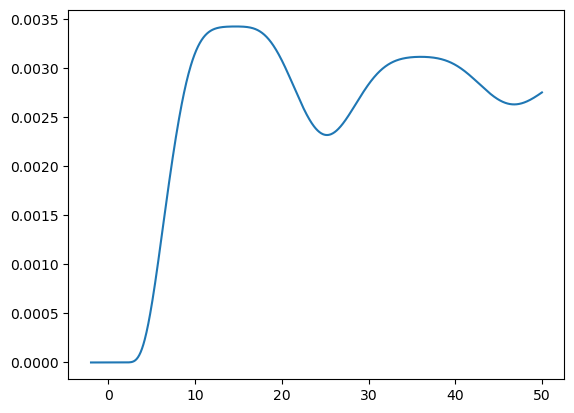

In [23]:
plt.plot(beta_eff_dict.keys(), reactivity)

In [24]:
np.array(list(beta_eff_dict.values()))

array([0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.006661  ,
       0.006661  , 0.006661  , 0.006661  , 0.006661  , 0.00666099,
       0.00666099, 0.00666099, 0.00666098, 0.00666097, 0.00666096,
       0.00666095, 0.00666094, 0.00666093, 0.00666091, 0.00666

In [25]:
ch.mdot.T

array([0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010185,
       0.12010185, 0.12010185, 0.12010185, 0.12010185, 0.12010